## Introduction

Facility Location Problems (FLPs) are classical optimization tasks. They aim at determining the best among potential sites for warehouses or factories.

Warehouses may or may not have a limited capacity. This distinguishes the capacitated (CFLP) from the uncapacitated (UFLP) variants of the problem.

The business goal to find the set of warehouse locations that minimize the costs. The original problem definition by Balinski (1965) minimizes the sum of two (annual) cost voices:

Transportation costs
Warehouse fixed costs
Transportation costs account for the expenses generated by reaching customers from the warehouse location. The warehouse fixed cost is location-specific. It may include, for instance, voices such as rent, taxes, electricity and maintenance.

Facility location is a well known subject and has a fairly rich literature. As such, many variants of the problem exist, as well as approaches. This post introduces the classical CFLP formulation and shares a practical Python example with PuLP.

## Problem Statement

The goal of CFLP is to determine the number and location of warehouses that will meet the customers demand while reducing fixed and transportation costs. Therefore, we can pose the problem as the minimization of the following objective function:

$$  \sum^{M}_{j=1} {f_j \cdot y_j} + \sum^{N}_{i=1}\sum^{M}_{j=1}t_{ij} \cdot x_{ij} $$

Where,

- $N$ is a set of customer locations.
- $M$ is a set of candidate warehouse locations.
- $f_j$ represent the annual fixed cost for warehouse $j$.
- $t_{ij}$ represents the cost of transportation from warehouse $j$ to customer $i$.
- $x_{ij}$ is the number of units delivered from warehouse $j$ to customer $i$.
- $y_j$ is a binary variable $y_j \in \{0,1\}$, indicating whether the warehouse should be built in the location $j$ $(y_j = 1)$ or not $(y_j = 0)$.


Let us now consider the addition of constraints to the objective function.

Since we are modeling a capacitated problem, each facility j can supply an annual maximum capacity $C_j$. Therefore, the number of units delivered to a customer $x_{ij}$ cannot be greater than this value:

$$ \sum^{N}_{i=1} x_{ij} \leq C_{j} \cdot y_j $$

The yearly units delivered from warehouse $j$ to customer $i$ must range between zero and $d_i$, the annual demand from customer $i$:

$$ 0 \leq x_{ij} \leq d_i \cdot y_j $$

And last but not least, we must meet customers’ demand. In this example, we impose that each warehouse serving a customer location must fully meet its demand:

$$ \sum^{M}_{j=1} x_{ij} = d_i$$



In conclusion, we can define the problem as follows:

$minimize$ $$  \sum^{M}_{j=1} {f_j \cdot y_j} + \sum^{N}_{i=1}\sum^{M}_{j=1}t_{ij} \cdot x_{ij} $$

$\text{subject to:}$
$$ \sum^{M}_{j=1} x_{ij} = d_i$$

$$ \sum^{N}_{i=1} x_{ij} \leq C_{j} \cdot y_j $$

$$ 0 \leq x_{ij} \leq d_i \cdot y_j $$

$$ y_j \in \{0, 1\} $$



In [1]:
import numpy as np
import pandas as pd
import geopandas
from math import sin, cos, asin, acos, radians
from shapely.geometry import Point

from pulp import LpProblem, LpMinimize, LpVariable, LpBinary, lpSum, LpStatus, value

import pickle

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
plt.style.use('ggplot')

## Load Data

In [2]:
itcities_data = pd.read_csv("data/it.csv", usecols = ['city', 'lat', 'lng', 'population', 'capital', 'admin_name'])
itcities_data

,city,lat,lng,admin_name,capital,population
0,Rome,41.8933,12.4828,Lazio,primary,2748109
1,Milan,45.4669,9.1900,Lombardy,admin,1354196
2,Naples,40.8333,14.2500,Campania,admin,913462
3,Turin,45.0792,7.6761,Piedmont,admin,841600
4,Palermo,38.1111,13.3517,Sicilia,admin,630167
...,...,...,...,...,...,...
302,Marina di Camerota,40.0000,15.3667,Campania,NaN,2674
303,Rosia,43.2475,11.2236,Tuscany,NaN,2573
304,Pellestrina,45.2723,12.3008,Veneto,NaN,2545
305,Petrignano,43.1039,12.5364,Umbria,NaN,2536


## Data Preprocessing

### Columns

We are interested in the following columns:

- city: name of the town;
- lat: latitude;
- lng: longitude;
- population: number of inhabitants;
- capital: indicates whether the city is a chief town or administrative center;
- state_name: name of the state
- county_name: name of the county

In [3]:
itcities_data.columns

Index(['city', 'lat', 'lng', 'admin_name', 'capital', 'population'], dtype='object')

### Customers, warehouses and demand

When creating customers, facility and demand, we assume that:
- Customers are a fraction (30%) of the input cities.
- Facilities can be established only in administrative centers. As a starting condition, we assume we could build warehouses in 80% of the Italian chief towns.
- Demand is constant and known through the year. It is equal to a fraction (2%) of the population of the customers’ towns plus an error term.

In [31]:
itcities_data['admin_name'].unique()

array(['Lazio', 'Lombardy', 'Campania', 'Piedmont', 'Sicilia', 'Liguria',
       'Emilia-Romagna', 'Tuscany', 'Puglia', 'Veneto', 'Calabria',
       'Friuli Venezia Giulia', 'Umbria', 'Sardegna', 'Abruzzo',
       'Trentino-Alto Adige', 'Marche', 'Basilicata', 'Molise',
       'Valle d’Aosta', nan], dtype=object)

In [32]:
itcities_data[itcities_data['admin_name'].isin([
    'Lombardy', 'Veneto', 'Emilia-Romagna', 'Sicilia', 'Campania', 'Piedmont', 'Puglia', 
    'Lazio', 'Calabria', 'Tuscany', 'Sardegna', 'Marche', 'Friuli-Venezia Giulia', 'Abruzzo',
    'Umbria', 'Trentino-Alto Adige', 'Liguria', 'Basilicata', 'Molise', 'Valle d’Aosta'])]

,city,lat,lng,admin_name,capital,population,demand
0,Rome,41.8933,12.4828,Lazio,primary,2748109,54966.0
1,Milan,45.4669,9.1900,Lombardy,admin,1354196,27092.0
2,Naples,40.8333,14.2500,Campania,admin,913462,18276.0
3,Turin,45.0792,7.6761,Piedmont,admin,841600,16837.0
4,Palermo,38.1111,13.3517,Sicilia,admin,630167,12603.0
...,...,...,...,...,...,...,...
300,Riva Ligure,43.8333,7.8833,Liguria,NaN,2805,56.0
302,Marina di Camerota,40.0000,15.3667,Campania,NaN,2674,62.0
303,Rosia,43.2475,11.2236,Tuscany,NaN,2573,47.0
304,Pellestrina,45.2723,12.3008,Veneto,NaN,2545,59.0


In [4]:
RANDOM_STATE = 2          # For reproducibility
FRACTION_CUSTOMERS = 0.3  # Fraction of cities we want to keep as customers
FRACTION_WAREHOUSES = 0.8 # Fraction of cities we want to keep as warehouse locations
FRACTION_DEMAND = 0.02    # Fraction of citizens of a city that may order a product  

# List of the 20 regions of Italy
REGION_LIST = [
    'Lombardy', 'Veneto', 'Emilia-Romagna', 'Sicilia', 'Campania', 'Piedmont', 'Puglia', 
    'Lazio', 'Calabria', 'Tuscany', 'Sardegna', 'Marche', 'Friuli-Venezia Giulia', 'Abruzzo',
    'Umbria', 'Trentino-Alto Adige', 'Liguria', 'Basilicata', 'Molise', 'Valle d’Aosta']

# Demand is composed of: 
#   1. A fraction of the population
#   2. An error term of uniform distribution
# Note: demand is approximated to the closest int 
# as its physical meaning denies decimals
itcities_data['demand'] = np.floor(
    FRACTION_DEMAND * itcities_data.population + np.random.uniform(-10, 10, size=(itcities_data.shape[0],)))

# Create the warehouses dataframe:
#   1. Filter the 20 regions of Italy
#   2. Filter capitals as candidate warehouse locations
#   3. Sample a fraction of the original cities
facility_df = itcities_data.\
                loc[itcities_data.admin_name.isin(REGION_LIST)].\
                loc[itcities_data.capital.isin(['admin', 'minor'])].\
                sample(frac=FRACTION_WAREHOUSES, random_state=RANDOM_STATE, ignore_index=True)

# Create the customers dataframe:
#   1. Filter the 20 regions of Italy
#   2. Sample a fraction of the original cities
customer_df = itcities_data.\
                loc[itcities_data.admin_name.isin(REGION_LIST)].\
                sample(frac=FRACTION_CUSTOMERS, random_state=RANDOM_STATE, ignore_index=True)

# Customers IDs list
customer_df['customer_id'] = range(1, 1 + customer_df.shape[0])

In [5]:
def add_geocoordinates(df, lat='lat', lng='lng'):
    assert pd.Series([lat, lng]).isin(df.columns).all(),\
        f'Cannot find columns "{lat}" and/or "{lng}" in the input dataframe.'
    return geopandas.GeoDataFrame(
        df, geometry=geopandas.points_from_xy(df.lng, df.lat))


customer_df = add_geocoordinates(customer_df)
facility_df = add_geocoordinates(facility_df)

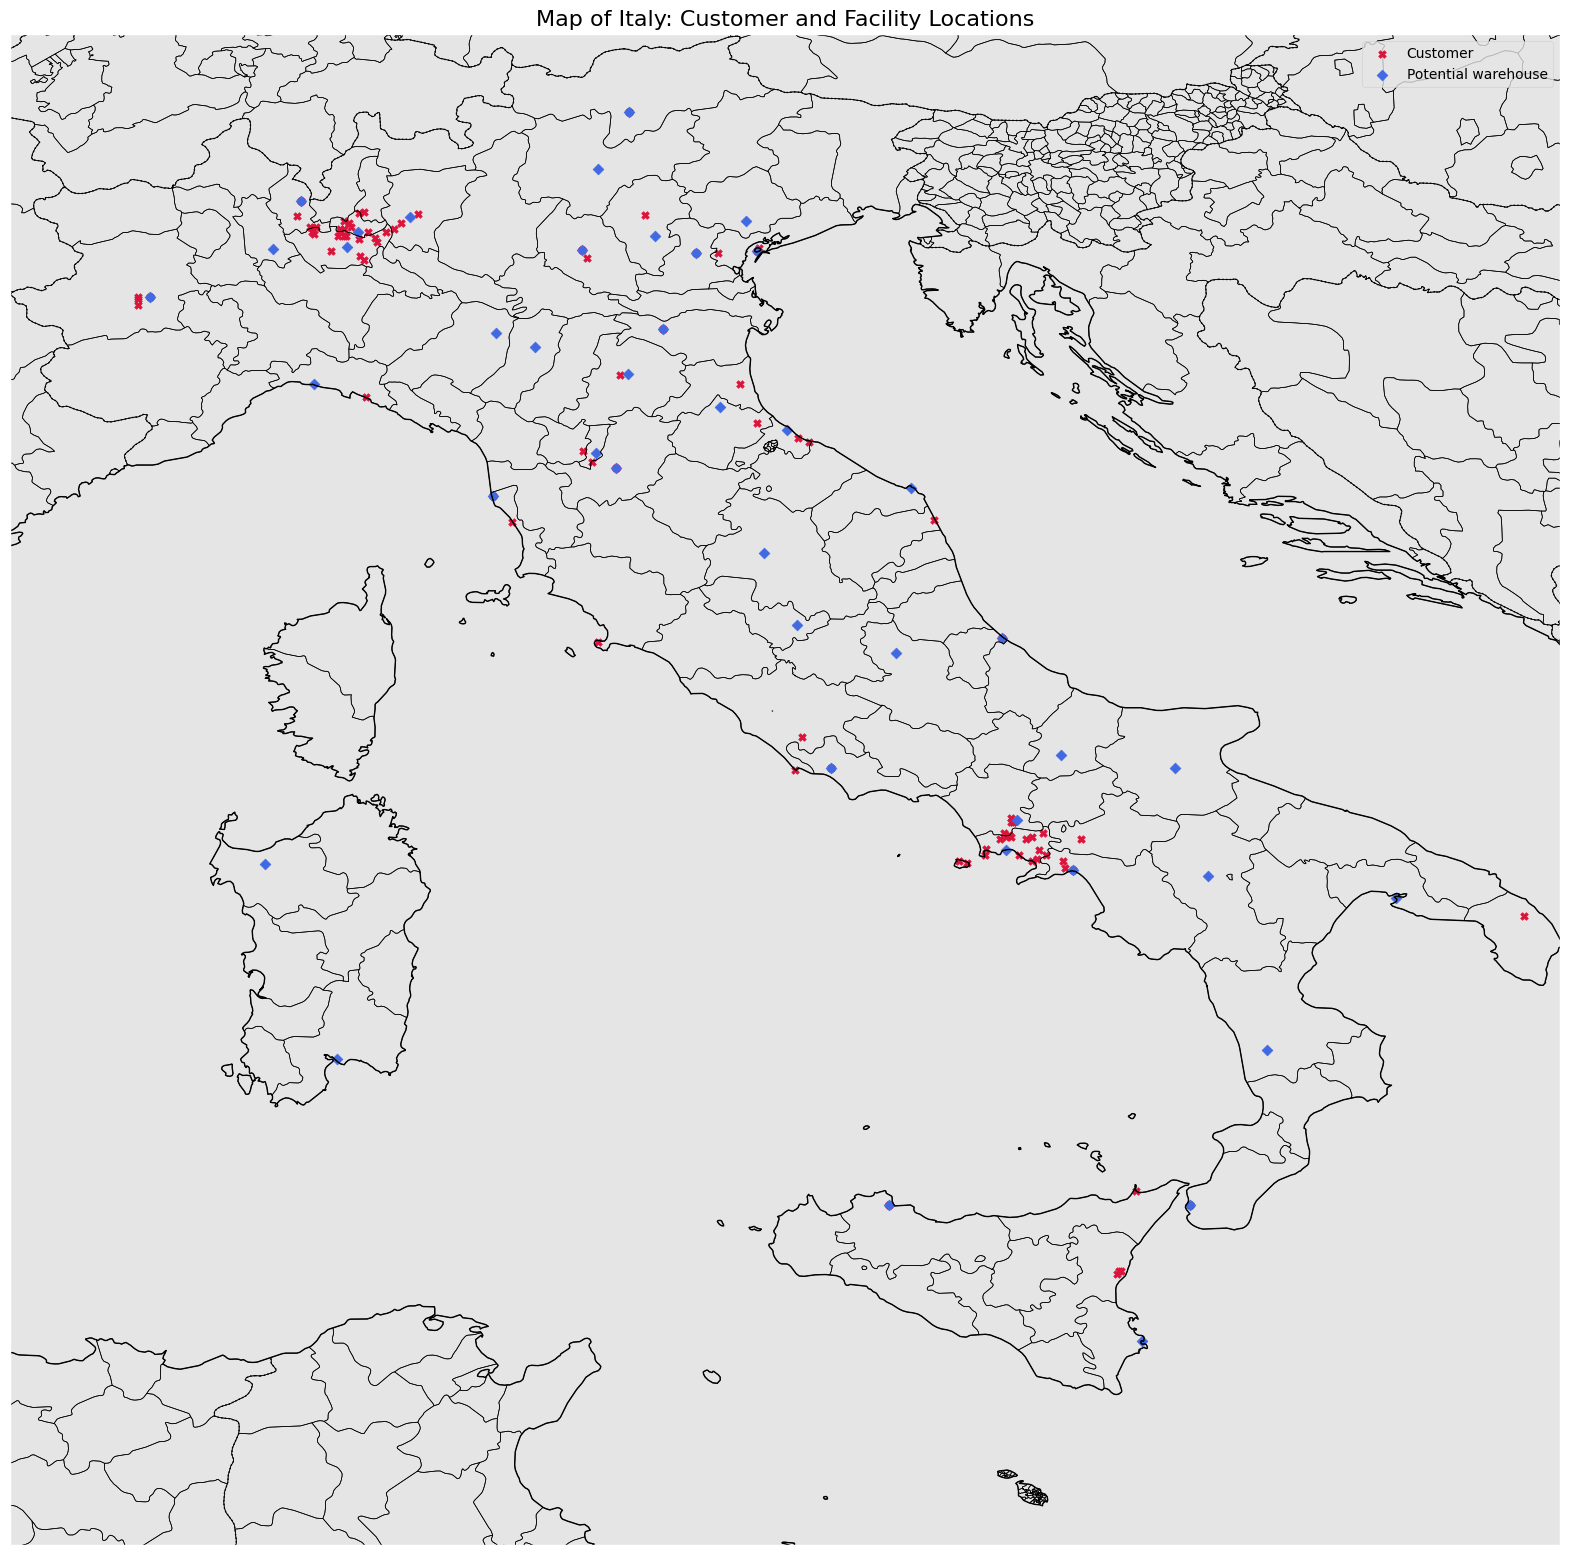

In [6]:
fig, ax = plt.subplots(figsize=(20, 30), subplot_kw={"projection": ccrs.PlateCarree()})
ax.set_extent([6.6, 18.5, 35.5, 47.1])  # Bounding box for Italy

# Add map features
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=1)
ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)

# Plot customer locations
customer_df.plot(
    ax=ax, marker='X', color='crimson', markersize=30, alpha=1, label='Customer'
)

# Plot facility locations
facility_df.plot(
    ax=ax, marker='D', color='royalblue', markersize=30, alpha=1, label='Potential warehouse'
)

# Add title and legend
plt.title("Map of Italy: Customer and Facility Locations", fontsize=16)
plt.legend()

plt.show()

In [7]:
# Prepare region dataframe:
#   1. Filter the 20 regions of Italy
#   2. Group by region
#   3. Calculate:
#      - Mean regional latitude
#      - Mean regional longitude
#      - Sum of regional demand
region_df = itcities_data.\
             loc[itcities_data.admin_name.isin(REGION_LIST)].\
             groupby(['admin_name']).\
             agg({'lat': 'mean', 'lng': 'mean', 'demand': 'sum'}).\
             reset_index()

# Add geo-coordinates
region_df = add_geocoordinates(region_df)

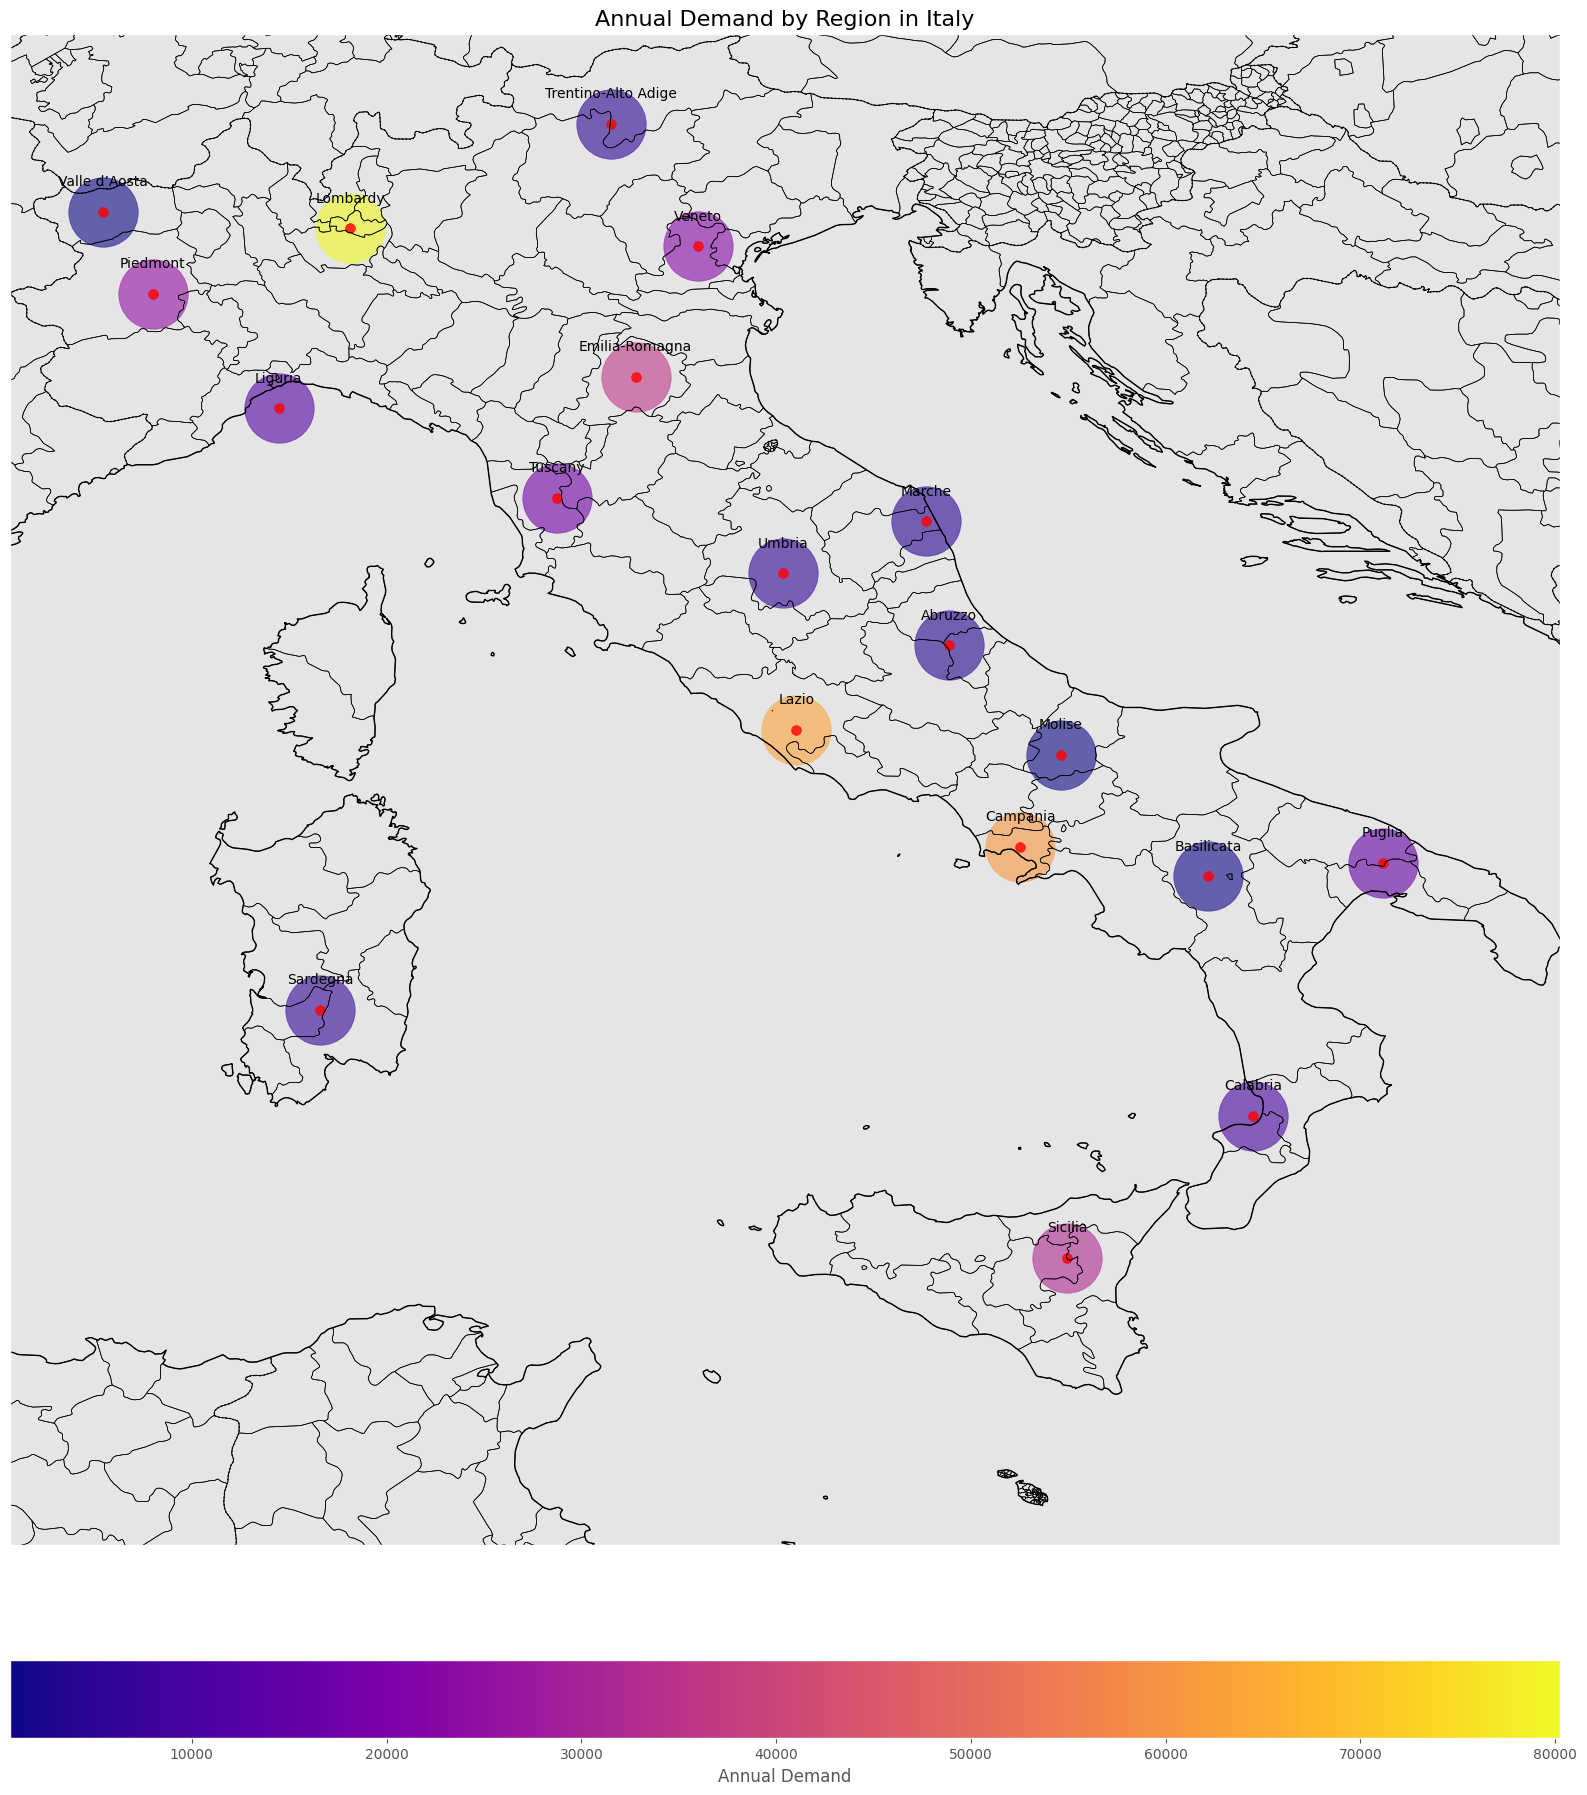

In [8]:
fig, ax = plt.subplots(figsize=(20, 30), subplot_kw={"projection": ccrs.PlateCarree()})
ax.set_extent([6.6, 18.5, 35.5, 47.1])  # Bounding box for Italy

# Add map features
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=1)
ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)

# Normalize the demand column for color scaling
norm = Normalize(vmin=region_df['demand'].min(), vmax=region_df['demand'].max())
cmap = plt.cm.plasma

# Plot each region as a circle, color-coded by demand
for _, row in region_df.iterrows():
    ax.scatter(
        row['lng'], row['lat'], 
        color=cmap(norm(row['demand'])), 
        s=2500, alpha=0.6, transform=ccrs.PlateCarree()
    )
    # Add red dots for region centers
    ax.scatter(
        row['lng'], row['lat'], 
        color='red', s=50, alpha=0.8, transform=ccrs.PlateCarree(), label='Customer location'
    )
    # Annotate with region name
    ax.text(
        row['lng'], row['lat'] + 0.2, 
        row['admin_name'], 
        horizontalalignment='center', fontsize=10, transform=ccrs.PlateCarree()
    )

# Add a color bar for demand
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', pad=0.05, fraction=0.05)
cbar.set_label('Annual Demand', fontsize=12)

# Add title
plt.title('Annual Demand by Region in Italy', fontsize=16)

# Show plot
plt.show()

In [26]:
facility_df

,city,lat,lng,admin_name,capital,population,demand,geometry,warehouse_id,build_warehouse
0,Vicenza,45.5500,11.5500,Veneto,minor,109823,2200.0,POINT (11.55 45.55),Warehouse 1,No
1,Siracusa,37.0692,15.2875,Sicilia,minor,116244,2319.0,POINT (15.2875 37.0692),Warehouse 2,No
2,Bergamo,45.6950,9.6700,Lombardy,minor,119534,2396.0,POINT (9.67 45.695),Warehouse 3,No
3,Bolzano,46.5000,11.3500,Trentino-Alto Adige,minor,106107,2126.0,POINT (11.35 46.5),Warehouse 4,Yes
4,Caserta,41.0667,14.3333,Campania,minor,72805,1462.0,POINT (14.3333 41.0667),Warehouse 5,No
5,Milan,45.4669,9.1900,Lombardy,admin,1354196,27092.0,POINT (9.19 45.4669),Warehouse 6,No
6,Ferrara,44.8333,11.6167,Emilia-Romagna,minor,129340,2590.0,POINT (11.6167 44.8333),Warehouse 7,Yes
7,Naples,40.8333,14.2500,Campania,admin,913462,18276.0,POINT (14.25 40.8333),Warehouse 8,Yes
8,Livorno,43.5519,10.3083,Tuscany,minor,152914,3048.0,POINT (10.3083 43.5519),Warehouse 9,Yes
9,Cosenza,39.3000,16.2500,Calabria,minor,200257,4009.0,POINT (16.25 39.3),Warehouse 10,No


In [27]:
customer_df

,city,lat,lng,admin_name,capital,population,demand,customer_id,geometry
0,Pomigliano d’Arco,40.9167,14.4000,Campania,NaN,39705,786.0,1,POINT (14.4 40.9167)
1,Porto Potenza Picena,43.3667,13.6943,Marche,NaN,7154,141.0,2,POINT (13.6943 43.3667)
2,Cattolica,43.9667,12.7333,Emilia-Romagna,NaN,16543,333.0,3,POINT (12.7333 43.9667)
3,Recale,41.0500,14.3000,Campania,NaN,7618,155.0,4,POINT (14.3 41.05)
4,Latina,41.4672,12.9036,Lazio,minor,127564,2551.0,5,POINT (12.9036 41.4672)
...,...,...,...,...,...,...,...,...,...
85,Reggio di Calabria,38.1114,15.6619,Calabria,minor,170951,3414.0,86,POINT (15.6619 38.1114)
86,Ferrara,44.8333,11.6167,Emilia-Romagna,minor,129340,2590.0,87,POINT (11.6167 44.8333)
87,Agrate Brianza,45.5833,9.3500,Lombardy,NaN,15547,319.0,88,POINT (9.35 45.5833)
88,Marigliano,40.9333,14.4500,Campania,NaN,29067,572.0,89,POINT (14.45 40.9333)


In [9]:
# Dictionary of cutomer id (id) and demand (value)
demand_dict = { customer : customer_df['demand'][i] for i, customer in enumerate(customer_df['customer_id']) }


In [33]:
demand_dict

{1: 786.0,
 2: 141.0,
 3: 333.0,
 4: 155.0,
 5: 2551.0,
 6: 162.0,
 7: 7227.0,
 8: 4123.0,
 9: 209.0,
 10: 830.0,
 11: 93.0,
 12: 598.0,
 13: 2549.0,
 14: 166.0,
 15: 694.0,
 16: 925.0,
 17: 787.0,
 18: 524.0,
 19: 516.0,
 20: 805.0,
 21: 2363.0,
 22: 16837.0,
 23: 372.0,
 24: 357.0,
 25: 249.0,
 26: 903.0,
 27: 273.0,
 28: 304.0,
 29: 139.0,
 30: 85.0,
 31: 557.0,
 32: 252.0,
 33: 107.0,
 34: 430.0,
 35: 363.0,
 36: 367.0,
 37: 164.0,
 38: 70.0,
 39: 1005.0,
 40: 698.0,
 41: 459.0,
 42: 1196.0,
 43: 2126.0,
 44: 4998.0,
 45: 75.0,
 46: 167.0,
 47: 566.0,
 48: 691.0,
 49: 961.0,
 50: 382.0,
 51: 198.0,
 52: 99.0,
 53: 544.0,
 54: 245.0,
 55: 477.0,
 56: 5121.0,
 57: 432.0,
 58: 281.0,
 59: 204.0,
 60: 340.0,
 61: 1176.0,
 62: 398.0,
 63: 274.0,
 64: 1558.0,
 65: 159.0,
 66: 3108.0,
 67: 437.0,
 68: 444.0,
 69: 607.0,
 70: 454.0,
 71: 716.0,
 72: 283.0,
 73: 199.0,
 74: 1525.0,
 75: 12603.0,
 76: 471.0,
 77: 90.0,
 78: 391.0,
 79: 510.0,
 80: 210.0,
 81: 732.0,
 82: 3048.0,
 83: 102.0,


### Supply and fixed costs

To model supply and fixed costs, we assume that:

- Each warehouse can meet a maximum yearly supply equal to 3 times the average regional demand.
- Each warehouse has a constant annual fixed cost of $ \$100,000.00 $ , independently from its location.
- As we did for the demand, we store supply and fixes costs in dictionaries:

In [10]:
# Assumptions: 
#    1. Each warehouse has an annual cost of 100.000,00 euros: rent, electricity, ...
#    2. Each warehouse can meet 3 times the regional average annual demand
COST_PER_WAREHOUSE = 100_000
SUPPLY_FACTOR_PER_WAREHOUSE = 3
SUPPLY_PER_WAREHOUSE = region_df.demand.mean() * SUPPLY_FACTOR_PER_WAREHOUSE

# Warehouses list
facility_df['warehouse_id'] = ['Warehouse ' + str(i) for i in range(1, 1 + facility_df.shape[0])]

# Dictionary of warehouse id (id) and max supply (value)
annual_supply_dict = { warehouse : SUPPLY_PER_WAREHOUSE for warehouse in facility_df['warehouse_id'] }

# Dictionary of warehouse id (id) and fixed costs (value)
annual_cost_dict = { warehouse : COST_PER_WAREHOUSE for warehouse in facility_df['warehouse_id'] }

In [29]:
annual_supply_dict

{'Warehouse 1': 63670.42105263158,
 'Warehouse 2': 63670.42105263158,
 'Warehouse 3': 63670.42105263158,
 'Warehouse 4': 63670.42105263158,
 'Warehouse 5': 63670.42105263158,
 'Warehouse 6': 63670.42105263158,
 'Warehouse 7': 63670.42105263158,
 'Warehouse 8': 63670.42105263158,
 'Warehouse 9': 63670.42105263158,
 'Warehouse 10': 63670.42105263158,
 'Warehouse 11': 63670.42105263158,
 'Warehouse 12': 63670.42105263158,
 'Warehouse 13': 63670.42105263158,
 'Warehouse 14': 63670.42105263158,
 'Warehouse 15': 63670.42105263158,
 'Warehouse 16': 63670.42105263158,
 'Warehouse 17': 63670.42105263158,
 'Warehouse 18': 63670.42105263158,
 'Warehouse 19': 63670.42105263158,
 'Warehouse 20': 63670.42105263158,
 'Warehouse 21': 63670.42105263158,
 'Warehouse 22': 63670.42105263158,
 'Warehouse 23': 63670.42105263158,
 'Warehouse 24': 63670.42105263158,
 'Warehouse 25': 63670.42105263158,
 'Warehouse 26': 63670.42105263158,
 'Warehouse 27': 63670.42105263158,
 'Warehouse 28': 63670.42105263158,
 

In [28]:
annual_cost_dict

{'Warehouse 1': 100000,
 'Warehouse 2': 100000,
 'Warehouse 3': 100000,
 'Warehouse 4': 100000,
 'Warehouse 5': 100000,
 'Warehouse 6': 100000,
 'Warehouse 7': 100000,
 'Warehouse 8': 100000,
 'Warehouse 9': 100000,
 'Warehouse 10': 100000,
 'Warehouse 11': 100000,
 'Warehouse 12': 100000,
 'Warehouse 13': 100000,
 'Warehouse 14': 100000,
 'Warehouse 15': 100000,
 'Warehouse 16': 100000,
 'Warehouse 17': 100000,
 'Warehouse 18': 100000,
 'Warehouse 19': 100000,
 'Warehouse 20': 100000,
 'Warehouse 21': 100000,
 'Warehouse 22': 100000,
 'Warehouse 23': 100000,
 'Warehouse 24': 100000,
 'Warehouse 25': 100000,
 'Warehouse 26': 100000,
 'Warehouse 27': 100000,
 'Warehouse 28': 100000,
 'Warehouse 29': 100000,
 'Warehouse 30': 100000,
 'Warehouse 31': 100000,
 'Warehouse 32': 100000,
 'Warehouse 33': 100000,
 'Warehouse 34': 100000,
 'Warehouse 35': 100000,
 'Warehouse 36': 100000,
 'Warehouse 37': 100000,
 'Warehouse 38': 100000,
 'Warehouse 39': 100000,
 'Warehouse 40': 100000,
 'Warehou

### Transportation costs

The estimate of transportation costs requires:

- the distance between the different locations, and
- a cost function per unit of distance.
- We can approximate the distance between two locations on a spherical surface using the Haversine formula:

### Test

For testing purpose i have considered the Yonkers,NY and New York City, NY

In actual, considering car navigation in map

<img src="map.png" width=400 height=300></img>

In [11]:
def haversine_distance(lat1, lon1, lat2, lon2):
    '''
    Calculate distance between two locations given latitude and longitude.

    Args:
       - lat1: latitude of the first location
       - lon1: longitude of the first location
       - lat2: latitude of the second location
       - lon2: longitude of the second location
    Out:
       - Distance in Km
    
    Ref: 
       - https://en.wikipedia.org/wiki/Haversine_formula
    '''
    return 6371.01 *\
            acos(sin(radians(lat1))*sin(radians(lat2)) +\
            cos(radians(lat1))*cos(radians(lat2))*cos(radians(lon1)-radians(lon2)))

In [12]:
haversine_distance(45.4654219, 9.1859243, 45.695000, 9.670000)

45.508144765533906

To modify the function for miles, we need to adjust the calculation to account for the distance in miles. Here's how it looks with the necessary conversion:

1. Average price of gasoline in the US (example): **\$3.50 per gallon** (you can adjust this based on updated data).
2. Average truck fuel efficiency: **6 miles per gallon** (example; you can refine this estimate).
3. Cost per mile:
  $$
   \text{Cost per mile} = \frac{\text{Price per gallon}}{\text{Miles per gallon}}
  $$

In [13]:
def traveling_cost(distance_in_miles, cost_per_gallon=3.50, mpg=6):
    cost_per_mile = cost_per_gallon / mpg
    return cost_per_mile * distance_in_miles

In [14]:
# Dict to store the distances between all warehouses and customers
transport_costs_dict = {}

# For each warehouse location
for i in range(0, facility_df.shape[0]):
    
    # Dict to store the distances between the i-th warehouse and all customers
    warehouse_transport_costs_dict = {}
    
    # For each customer location
    for j in range(0, customer_df.shape[0]):
        
        # Distance in Km between warehouse i and customer j
        d = 0 if facility_df.city[i]==customer_df.city[j] else haversine_distance(
            facility_df.lat[i], facility_df.lng[i], customer_df.lat[j], customer_df.lng[j])
        
        # Update costs for warehouse i
        warehouse_transport_costs_dict.update({customer_df.customer_id[j]: traveling_cost(d)})
    
    # Final dictionary with all costs for all warehouses
    transport_costs_dict.update({facility_df.warehouse_id[i]: warehouse_transport_costs_dict})

In [15]:
# transport_costs_df = pd.DataFrame(transport_costs_dict)

# transport_costs_df

In [16]:
# transport_costs_df.to_csv('transport_costs_df.csv', index=False)

In [17]:
# transport_costs_df = pd.read_csv("transport_costs_df.csv")
# transport_costs_dict = transport_costs_df.to_dict()
# transport_costs_dict

### Optimization

Let us remind the optimization problem:

$minimize$ $$  \sum^{M}_{j=1} {f_j \cdot y_j} + \sum^{N}_{i=1}\sum^{M}_{j=1}t_{ij} \cdot x_{ij} $$

$\text{subject to:}$
$$ \sum^{M}_{j=1} x_{ij} = d_i$$

$$ \sum^{N}_{i=1} x_{ij} \leq C_{j} \cdot y_j $$

$$ 0 \leq x_{ij} \leq d_i \cdot y_j $$

$$ y_j \in \{0, 1\} $$


In [18]:
# Define linear problem
lp_problem = LpProblem('CFLP', LpMinimize)


# Variable: y_j (constraint: it is binary)
created_facility = LpVariable.dicts(
    'Create_facility', facility_df['warehouse_id'], 0, 1, LpBinary)

# Variable: x_ij
served_customer = LpVariable.dicts(
    'Link', [(i,j) for i in customer_df['customer_id'] for j in facility_df['warehouse_id']], 0)


# Objective function 
objective = lpSum(annual_cost_dict[j]*created_facility[j] for j in facility_df['warehouse_id']) +\
            lpSum(transport_costs_dict[j][i]*served_customer[(i,j)] \
                  for j in facility_df['warehouse_id'] for i in customer_df['customer_id'])

lp_problem += objective

# Costraint: the demand must be met
for i in customer_df['customer_id']:
    lp_problem += lpSum(served_customer[(i,j)] for j in facility_df['warehouse_id']) == demand_dict[i]

# Constraint: a warehouse cannot deliver more than its capacity limit
for j in facility_df['warehouse_id']:
    lp_problem += lpSum(served_customer[(i,j)] for i in customer_df['customer_id']) <= annual_supply_dict[j] * created_facility[j]

# Constraint: a warehouse cannot give a customer more than its demand
for i in customer_df['customer_id']:
    for j in facility_df['warehouse_id']:
        lp_problem += served_customer[(i,j)] <= demand_dict[i] * created_facility[j]


In [19]:
lp_problem.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/jeeva/anaconda3/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/9s/5vl8qm5n629_ld9lvn25vm2c0000gn/T/5256bb5a5e7e435e94e50b229e04e197-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/9s/5vl8qm5n629_ld9lvn25vm2c0000gn/T/5256bb5a5e7e435e94e50b229e04e197-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 3917 COLUMNS
At line 22972 RHS
At line 26885 BOUNDS
At line 26928 ENDATA
Problem MODEL has 3912 rows, 3822 columns and 15162 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 2.14925e+06 - 0.01 seconds
Cgl0004I processed model has 3912 rows, 3822 columns (42 integer (42 of which binary)) and 15162 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 1.11022e-15
Cbc0038I Solution found of 2.14925e+06
Cbc0038I Relaxing continuous g

1

In [20]:
print('Solution: ', LpStatus[lp_problem.status])

Solution:  Optimal


In [21]:
value(lp_problem.objective)


2149250.558464989

In [22]:
created_facility['Warehouse 1'].varValue


0.0

In [23]:
facility_values = [i.varValue for i in created_facility.values()]

[[i, facility_values.count(i)] for i in set(facility_values)]


[[0.0, 28], [1.0, 14]]

In [24]:
facility_df['build_warehouse'] = ''

for i in facility_df['warehouse_id']:
    if created_facility[i].varValue == 1:
        print('Build site at: ', i)
        facility_df.loc[facility_df['warehouse_id'] == i, 'build_warehouse'] = 'Yes'
    else:
        facility_df.loc[facility_df['warehouse_id'] == i, 'build_warehouse'] = 'No'

Build site at:  Warehouse 4
Build site at:  Warehouse 7
Build site at:  Warehouse 8
Build site at:  Warehouse 9
Build site at:  Warehouse 11
Build site at:  Warehouse 12
Build site at:  Warehouse 13
Build site at:  Warehouse 22
Build site at:  Warehouse 23
Build site at:  Warehouse 25
Build site at:  Warehouse 27
Build site at:  Warehouse 28
Build site at:  Warehouse 30
Build site at:  Warehouse 35


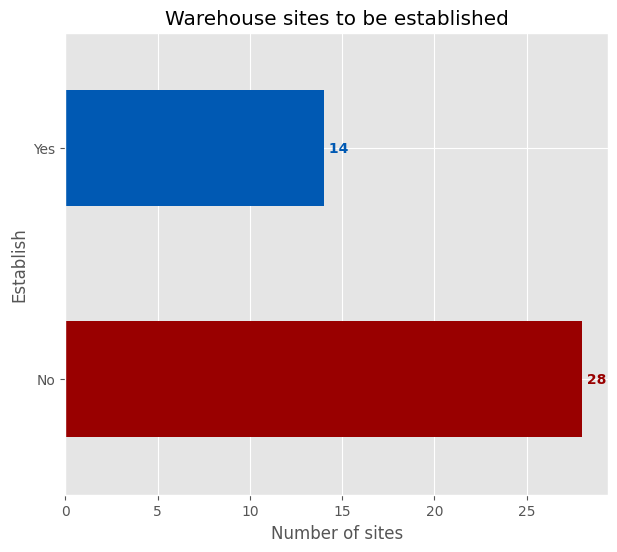

In [25]:
colors = ['#990000', '#0059b3']

facility_df.build_warehouse.value_counts().plot.barh(
  title='Warehouse sites to be established', xlabel='Number of sites', color=colors, ylabel='Establish', figsize=(7,6)) 

for i, v in enumerate(facility_df.build_warehouse.value_counts()):
    plt.text(v, i, ' '+str(round(v,3)), color=colors[i], va='center', fontweight='bold')
